In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd
import pickle

from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.network.heterogeneous_network import HeterogeneousNetwork

from moge.visualization.plot_data import matrix_heatmap, bar_chart
from moge.network.edge_generator import DataGenerator
from moge.visualization.visualize_embedding import visualize_embedding, plot_bokeh_graph

# from bokeh.io import output_notebook
# output_notebook()

Using TensorFlow backend.


#  Import network from file

In [2]:
with open('moge/data/luad_data_longest.pickle', 'rb') as file:
    luad_data = pickle.load(file)
#     network.multi_omics_data = luad_data
#     network_val.multi_omics_data = luad_data


In [3]:
from moge.network.heterogeneous_network import get_rename_dict
noncode_rename_dict = pd.Series(luad_data.LNC.noncode_func_df["Gene Name"].values,
     index=luad_data.LNC.noncode_func_df["NONCODE Gene ID"].str.split(".", expand=True)[0]).to_dict()
noncode_rename_dict = {k: noncode_rename_dict[k] for k in noncode_rename_dict if type(noncode_rename_dict[k])!=float}

lncbase_rename_dict = get_rename_dict(luad_data.LNC.get_genes_info(), "Gene ID")
lncbase_rename_dict.update(noncode_rename_dict)

In [33]:
# READ
# with open('moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/LMN_lncbase_mirtarbase_biogrid_npinter_lncrna2target.train.pickle', 'rb') as file:
with open('moge/data/LMN_future_recall/TEST/Interactions_Affinity/LMN_lncbase_mirtarbase_biogrid_npinter_lncrna2target.latest.pickle', 'rb') as file:
    network = pickle.load(file)
    network.preprocess_graph()
    network.process_genes_info()
    
network.G.remove_edges_from([(u,v,d) for u,v,d in network.G.edges(data=True) if "database" in d and \
                             d["database"]=="NPInter" and u in network.nodes["GE"]])

MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 58980
Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'Chromosome', 'GO Terms', 'Family']


In [5]:
# READ edgelists
with open('moge/data/LMN_future_recall/TEST/Interactions_Affinity/LMN_lncbase_mirtarbase_biogrid_npinter_lncrna2target.test_v2.pickle', 'rb') as file:
    network_val = pickle.load(file)
    network_val.preprocess_graph()
    network_val.process_genes_info()
    
network_val.G.remove_edges_from([(u,v,d) for u,v,d in network_val.G.edges(data=True) if "database" in d and \
                             d["database"]=="NPInter" and u in network.nodes["GE"]])
network_val.G = nx.relabel_nodes(network_val.G, lncbase_rename_dict)

MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 58986
Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'Chromosome', 'GO Terms', 'Family']


In [6]:
# with open('moge/data/luad_data_shortest.pickle', 'rb') as file:
#     luad_data = pickle.load(file)
#     network.multi_omics_data = luad_data
#     network.process_genes_info()

In [7]:
network.genes_info["Transcript length"] = network.genes_info["Transcript sequence"].apply(lambda x: len(x) if type(x) == str else None)
network.genes_info["Transcript length"].describe(percentiles=[.50, .75, .85, .90, .95, .99])

count     32741.000000
mean       2670.878715
std        2783.388100
min          41.000000
50%        1979.000000
75%        3780.000000
85%        5008.000000
90%        5928.000000
95%        7686.000000
99%       12322.600000
max      109224.000000
Name: Transcript length, dtype: float64

# Data Visualization

In [8]:
# matrix_heatmap(network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list).todense())

In [9]:
# matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list).todense())

In [10]:
# matrix_heatmap(network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.node_list).todense())

In [11]:
# The test data to recall
# matrix_heatmap(network_val.get_adjacency_matrix(edge_types=["d"], node_list=network_val.node_list).todense())

# Train

In [11]:
params = {
    'weighted': True,
 
 'truncating': 'random',
 'source_target_dense_layers': True,
 'negative_sampling_ratio': 5.0,
 'max_length': 5050,
 'max2_pool_size': 6,
 'max1_pool_size': 9,
 'margin': 1.0,
 'lstm_unit_size': 320,
 'lr': 0.0005,
 'embedding_normalization': False,
 'directed_proba': 1.0,
    'directed_distance': 'dot_sigmoid',
    'undirected_distance': 'dot_softmax',
 'dense2_unit_size': 512,
 'dense1_unit_size': None,
 'd': 128,
 'conv2_kernel_size': 6,
 'conv2_batch_norm': True,
 'conv1_kernel_size': 6,
 'conv1_batch_norm': True,
 'compression_func': 'sqrt3'}


In [12]:
from moge.embedding.siamese_graph_embedding import SiameseGraphEmbedding
from moge.embedding.siamese_triplet_online_embedding import SiameseOnlineTripletGraphEmbedding

siamese = SiameseOnlineTripletGraphEmbedding(batch_size=225, margin=params["margin"], epochs=200, verbose=True)
# siamese = SiameseGraphEmbedding(batch_size=500, epochs=10, verbose=True)

# siamese = SiameseTripletGraphEmbedding(d=128, batch_size=256, margin=0.2, lr=0.001, epochs=30, 
#     negative_sampling_ratio=2.0, directed_proba=0.8, compression_func="sqrt3",
#     max_length=2000, truncating="post", verbose=True)

siamese.set_params(**params)

SiameseOnlineTripletGraphEmbedding(batch_size=225, compression_func='sqrt3',
                  conv1_batch_norm=True, conv1_kernel_size=6,
                  conv2_batch_norm=True, conv2_kernel_size=6, d=128,
                  dense1_unit_size=None, dense2_unit_size=512,
                  directed_distance='dot_sigmoid', directed_proba=1.0,
                  embedding_normalization=False, epochs=200, lr=0.0005,
                  lstm_unit_size=320, margin=1.0, max1_pool_size=9,
                  max2_pool_size=6, max_length=5050,
                  negative_sampling_ratio=5.0, seed=0,
                  source_target_dense_layers=True, truncating='random',
                  undirected_distance='dot_softmax', verbose=True,
                  weighted=True)

In [31]:
# import yaml
# with open("logs/SiameseGraphEmbeddin_03-29_11-50PM/params.txt", "r") as file:
#     params = yaml.load(str(file.read()))
#     params["subsample"] = False
#     siamese.set_params(**params)
#     file.close()
    
# siamese.load_model("logs/SiameseGraphEmbeddin_03-29_11-50PM/lstm_model.e5.h5", network)

In [10]:
siamese.learn_embedding(network, network_val=network_val, 
                        multi_gpu=False, rebuild_model=False,
                        n_steps=1000, 
                        validation_steps=250,
                        tensorboard=True,
                        early_stopping=0,
                        initial_epoch=0,
                        seed=0),

Epoch 1/200
1000/1000 [==============================] - 308s 308ms/step - loss: 0.3009 - _precision: 0.5731 - _recall: 0.7173 - val_loss: nan - val__precision: 0.5335 - val__recall: 0.0948
Epoch 2/200
1000/1000 [==============================] - 308s 308ms/step - loss: 0.2342 - _precision: 0.8119 - _recall: 0.6796 - val_loss: nan - val__precision: 0.5040 - val__recall: 0.1326
Epoch 3/200
1000/1000 [==============================] - 307s 307ms/step - loss: 0.2226 - _precision: 0.8417 - _recall: 0.7203 - val_loss: nan - val__precision: 0.5676 - val__recall: 0.0995
Epoch 4/200
1000/1000 [==============================] - 307s 307ms/step - loss: 0.2146 - _precision: 0.8579 - _recall: 0.7534 - val_loss: nan - val__precision: 0.5001 - val__recall: 0.0765
Epoch 5/200
1000/1000 [==============================] - 308s 308ms/step - loss: 0.2080 - _precision: 0.8723 - _recall: 0.7824 - val_loss: nan - val__precision: 0.5643 - val__recall: 0.1656
Epoch 6/200
1000/1000 [===========================

Process ForkPoolWorker-313:
Process ForkPoolWorker-311:
Process ForkPoolWorker-316:
Process ForkPoolWorker-320:
Process ForkPoolWorker-310:
Process ForkPoolWorker-319:
Process ForkPoolWorker-306:
Process ForkPoolWorker-314:
Process ForkPoolWorker-315:
Process ForkPoolWorker-318:
Process ForkPoolWorker-305:
Process ForkPoolWorker-307:
Process ForkPoolWorker-312:
Process ForkPoolWorker-308:
Traceback (most recent call last):
Process ForkPoolWorker-317:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-309:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    sel

  File "/opt/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/opt/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/opt/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
   

Stop training


(None,)

# Visualize Embeddings

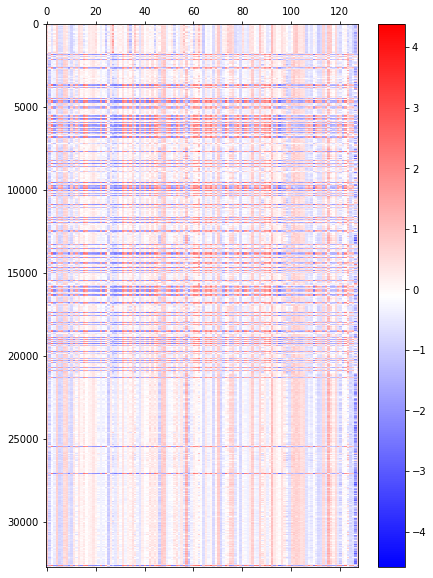

In [13]:
matrix_heatmap(siamese.get_embedding(recompute=True), cmap="bwr", aspect='auto', figsize=(7,10))

Dot product & sigmoid


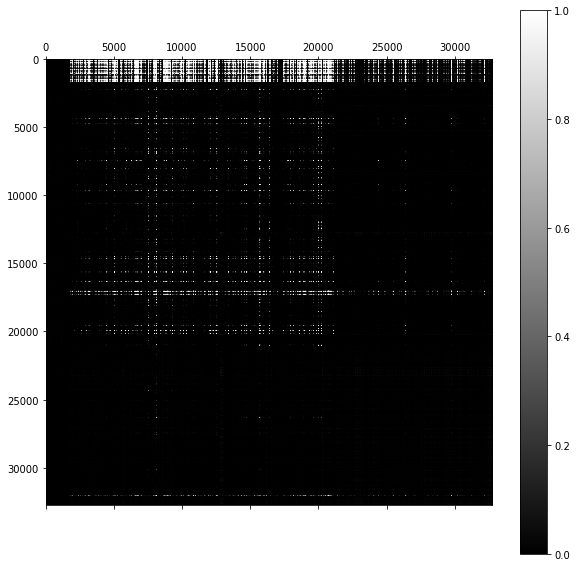

In [14]:
delattr(siamese, "reconstructed_adj") if hasattr(siamese, "reconstructed_adj") else None
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="d", 
#                                              interpolate=False,
#                                              node_l=siamese.generator_train.get_nonzero_nodelist(),
                                            ), figsize=(10, 10))

/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


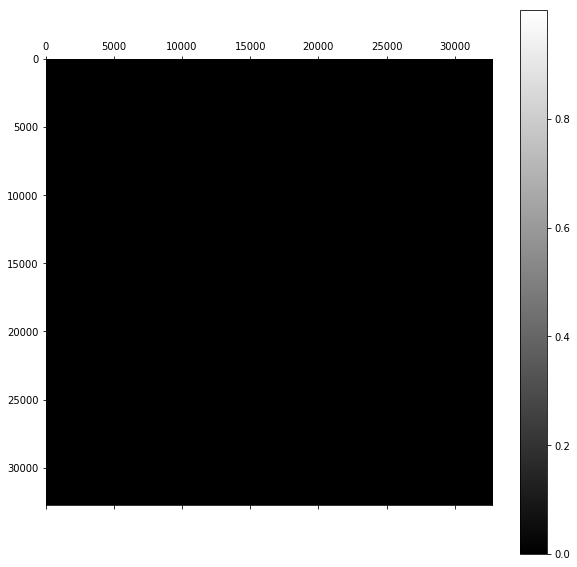

In [15]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="u", 
#                                              node_l=siamese.generator_train.get_nonzero_nodelist(), 
                                             ), figsize=(10,10))

# Save Model & Embedding

In [ ]:
# siamese.save_model("lstm_model.h5", model="lstm", logdir=True)

In [ ]:
# siamese.truncating = "post"
# siamese.save_embeddings("lmn_train.triplet.shortest.biogrid.full.euclidean.trunc.emb", 
#                         variable_length=False, recompute=False, minlen=100)

In [ ]:
siamese.log_dir

# Import different models

In [16]:
from moge.embedding.static_graph_embedding import ImportedGraphEmbedding
from moge.embedding.sequence_based_embedding import BioVecEmbedding, iDeepVEmbedding, LncTarInteraction

nodelist = network.genes_info.index.tolist()

# biovec_emb = BioVecEmbedding(network, {"MIR": "moge/data/biovec/miRNA_protvec.model",
#                          "GE": "moge/data/biovec/mRNA_protvec.model",
#                          "LNC": "moge/data/biovec/lncRNA_protvec.model"})

node2vec_emb = ImportedGraphEmbedding(d=128, method_name="node2vec")
node2vec_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.node2vec.emb", 
                          node_list=nodelist)


biovec_emb = ImportedGraphEmbedding(d=100, method_name="BioVec")
biovec_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.biovec.emb", 
                          node_list=nodelist)

line_emb = ImportedGraphEmbedding(d=128, method_name="LINE")
line_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.line.emb", 
                          node_list=nodelist)

hope_emb = ImportedGraphEmbedding(d=128, method_name="HOPE")
hope_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.hope.emb", 
                          node_list=nodelist)

sdne_emb = ImportedGraphEmbedding(d=128, method_name="SDNE")
sdne_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.sdne.emb", 
                          node_list=nodelist)


rna2rna_emb = ImportedGraphEmbedding(d=128, method_name="rna2rna")
rna2rna_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_train.siamese.multi_seq_UT.biogrid.full.euclidean.trunc.emb", 
                         node_list=network.node_list)
rna2rna_emb.network = network

print()

node2vec imported (21355, 128)
BioVec imported (32707, 100)
LINE imported (21355, 128)
HOPE imported (21355, 128)
SDNE imported (21355, 128)
rna2rna imported (32697, 128)



In [ ]:
# rna2rna_graph = nx.from_numpy_matrix(rna2rna_emb.get_reconstructed_adj(), create_using=nx.DiGraph())

In [ ]:
# delattr(rna2rna_emb, "reconstructed_adj") if hasattr(rna2rna_emb, "reconstructed_adj") else None
# matrix_heatmap(rna2rna_emb.get_reconstructed_adj())

In [17]:
methods = {}
methods["node2vec"] = node2vec_emb
methods["LINE"] = line_emb
methods["HOPE"] = hope_emb
methods["SDNE"] = sdne_emb
methods["BioVec"] = biovec_emb
# methods["rna2rna"] = rna2rna_emb
methods["rna2rna"] = siamese

# Prepare Validation Set

In [18]:
generator_val = DataGenerator(network=network_val, 
                             negative_sampling_ratio=1.0,
                             batch_size=1,
#                              maxlen=siamese.max_length,
                             truncating="post",
                             shuffle=True, seed=1,
                             training_network=network)
generator_val.on_epoch_end()

Ed_count: 269442 , Eu_count: 0 , En_count: 0
Ens_count: 269442
word index: {'A': 1, 'G': 2, 'T': 3, 'C': 4}


lncrna2target
Ed_count: 18013 , Eu_count: 0 , En_count: 0 , Ens_count 18013


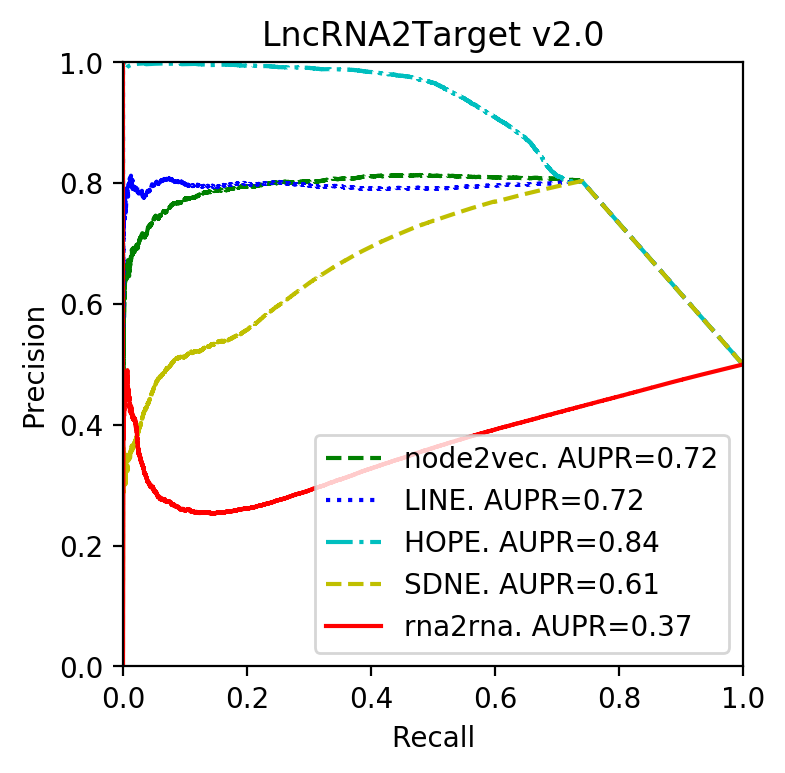

lncBase
Ed_count: 156149 , Eu_count: 0 , En_count: 0 , Ens_count 156149


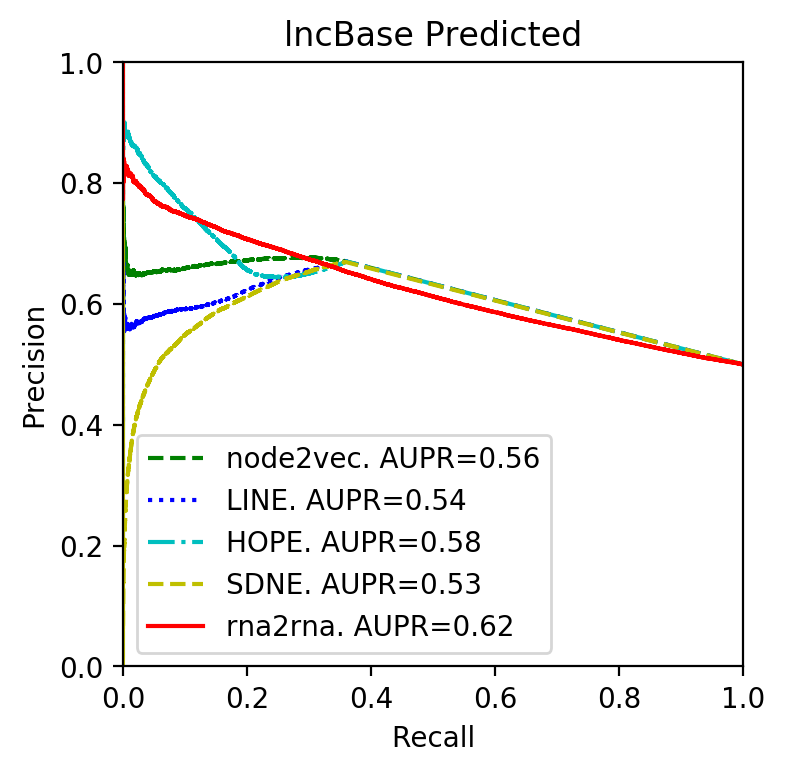

miRTarBase
Ed_count: 55891 , Eu_count: 0 , En_count: 0 , Ens_count 55891


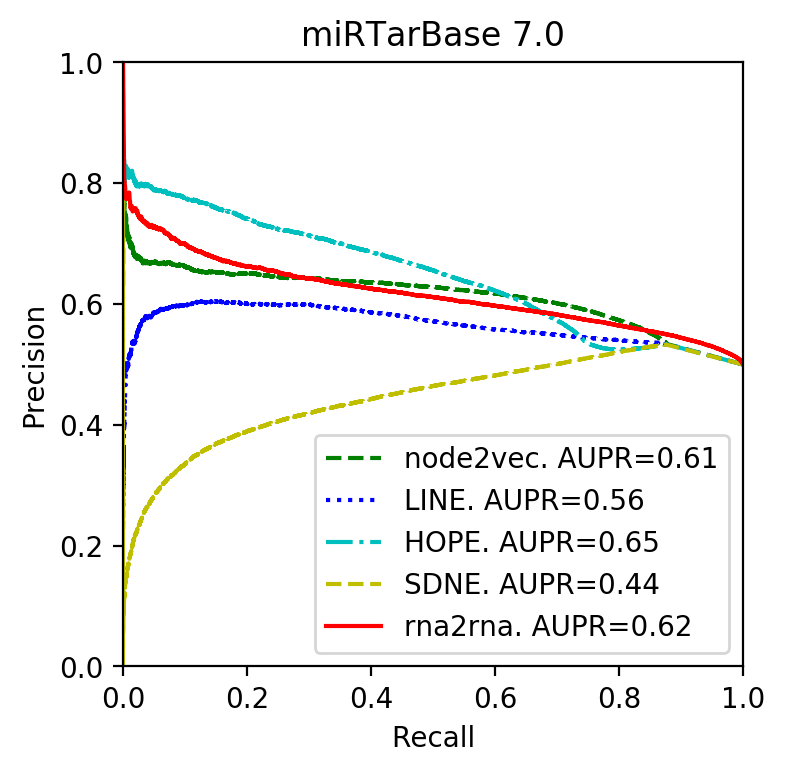

BioGRID
Ed_count: 31633 , Eu_count: 0 , En_count: 0 , Ens_count 31633


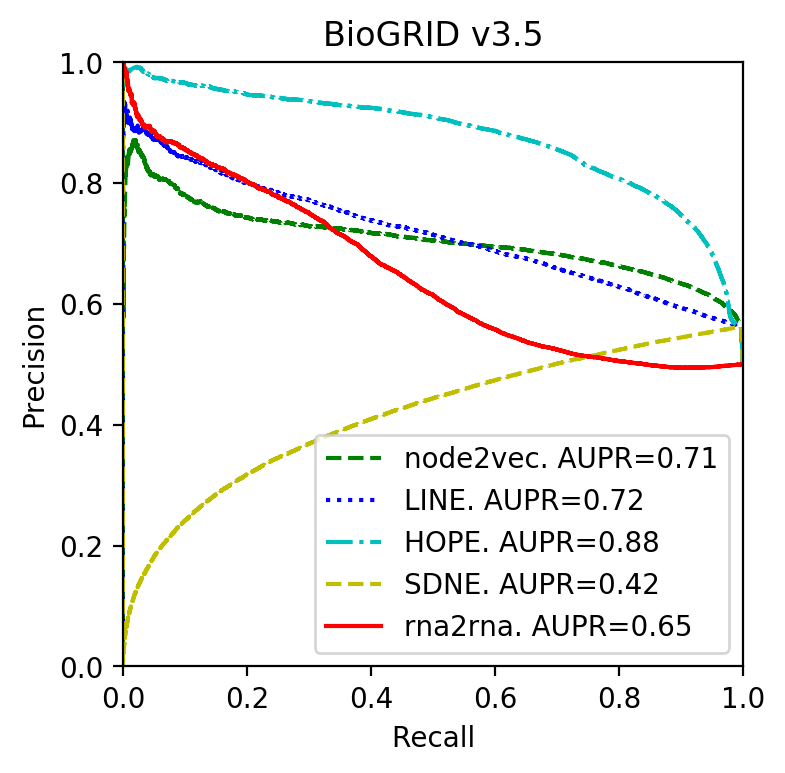

NPInter
Ed_count: 7756 , Eu_count: 0 , En_count: 0 , Ens_count 7756


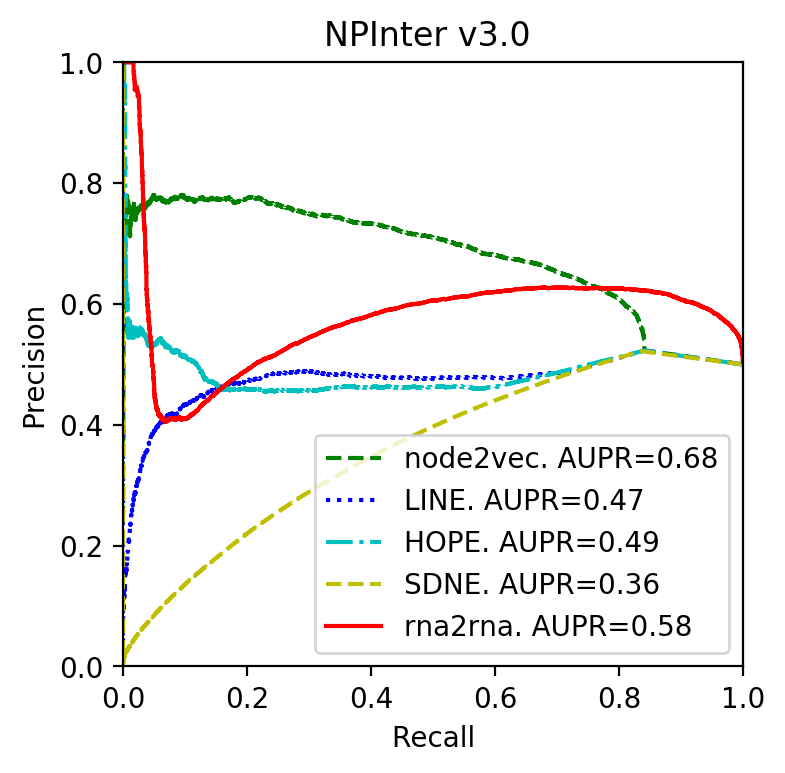

In [19]:
from moge.evaluation.link_prediction import evaluate_pr_curve_link_pred, evaluate_pr_curve_link_pred_by_database
# evaluate_pr_curve_link_pred(methods, X, y_true)
evaluate_pr_curve_link_pred_by_database(methods, generator_val, 
                                        tests=[
                                            ("LNC", "GE", "lncrna2target", "LncRNA2Target v2.0"),
                                            ("MIR", "LNC", "lncBase", "lncBase Predicted"),
                                            ("MIR", "GE", "miRTarBase", "miRTarBase 7.0"), 
                                            ("GE", "GE", "BioGRID", "BioGRID v3.5"), 
                                            (None, None, "NPInter", "NPInter v3.0 "),
#                                             ("LNC", "GE", "lncRInter"),
#                                             ("LNC", "GE", "LncReg"),
                                              ])

In [20]:
isolates = nx.isolates(network_val.G)
network_val.G.remove_nodes_from(list(isolates))
isolates = nx.isolates(network.G)
network.G.remove_nodes_from(list(isolates))
novel_nodes = list(set(network_val.G.nodes()) - set(network.G.nodes()))
print(len(novel_nodes), {modality:len(set(novel_nodes) & set(network.nodes[modality])) for modality in ["LNC", "MIR", "GE"]})
novel_edges = list(network_val.G.edges(novel_nodes, data=True))
print(len(novel_edges))
network_val.G.clear()
network_val.G.add_edges_from(novel_edges)

generator_val_novel = DataGenerator(network=network_val, 
                             negative_sampling_ratio=1.0,
                             batch_size=1,
#                              maxlen=siamese.max_length,
                             truncating="post",
                             shuffle=True, seed=1,
                             training_network=network)
generator_val_novel.on_epoch_end()

32495 {'LNC': 9210, 'MIR': 4, 'GE': 1722}
96083
Ed_count: 4298 , Eu_count: 0 , En_count: 0
Ens_count: 4298
word index: {'A': 1, 'G': 2, 'T': 3, 'C': 4}


lncrna2target
Ed_count: 3052 , Eu_count: 0 , En_count: 0 , Ens_count 3052


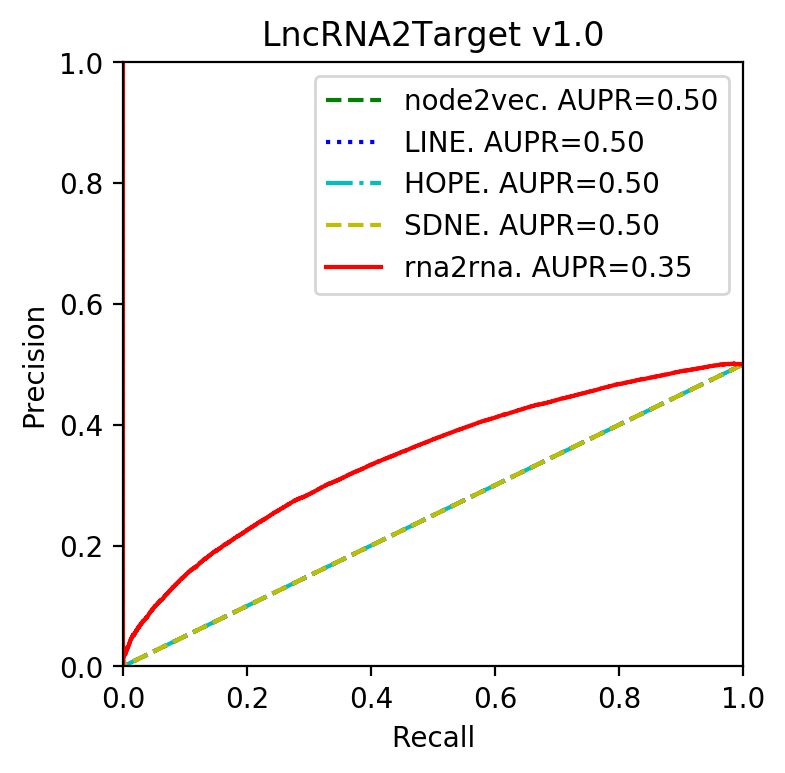

lncBase
Ed_count: 0 , Eu_count: 0 , En_count: 0 , Ens_count 0
miRTarBase
Ed_count: 0 , Eu_count: 0 , En_count: 0 , Ens_count 0
BioGRID
Ed_count: 14 , Eu_count: 0 , En_count: 0 , Ens_count 14


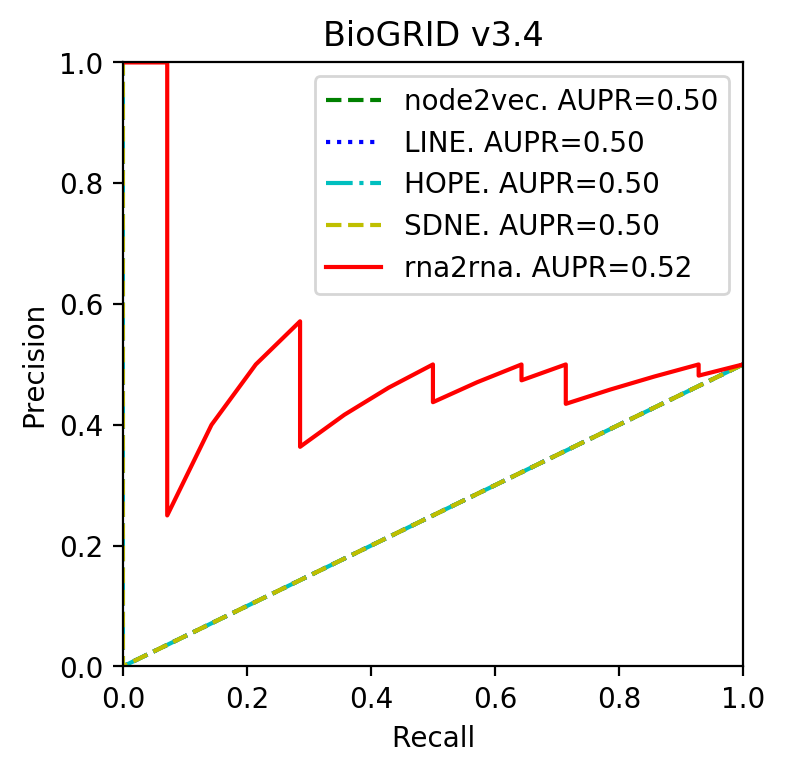

NPInter
Ed_count: 1232 , Eu_count: 0 , En_count: 0 , Ens_count 1232


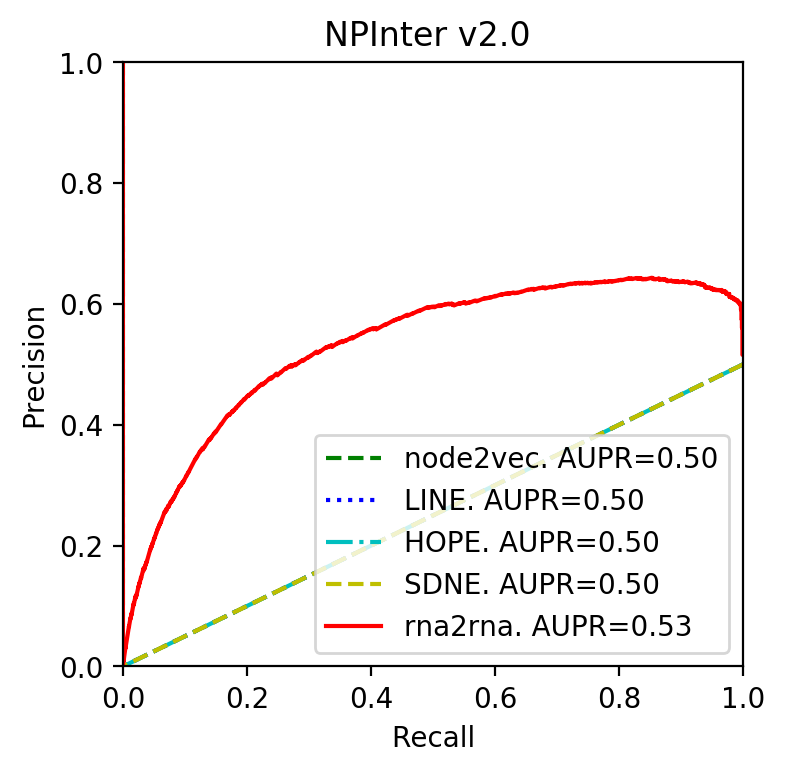

In [21]:
evaluate_pr_curve_link_pred_by_database(methods, generator_val_novel, 
                                        tests=[
                                            ("LNC", "GE", "lncrna2target", "LncRNA2Target v1.0"),
                                            ("MIR", "LNC", "lncBase", "lncBase v2"),
                                            ("MIR", "GE", "miRTarBase", "miRTarBase 6.0"), 
                                            ("GE", "GE", "BioGRID", "BioGRID v3.4"), 
                                            (None, None, "NPInter", "NPInter v2.0 "),
#                                             ("LNC", "GE", "lncRInter"),
#                                             ("LNC", "GE", "LncReg"),
                                              ])
with open('moge/data/LMN_future_recall/TEST/Interactions_Affinity/LMN_lncbase_mirtarbase_biogrid_npinter_lncrna2target.test_v2.pickle', 'rb') as file:
    network_val = pickle.load(file)

# Prepare Training set (for graph reconstruction)

In [22]:
from moge.network.edge_generator import DataGenerator

generator_train = DataGenerator(network=network, 
                             negative_sampling_ratio=1.0,
                             batch_size=1,
#                              maxlen=siamese.max_length,
                             truncating="post",
                             shuffle=True, seed=1)
generator_train.Eu_count = 0
generator_train.En_count = 0
generator_train.on_epoch_end()

Ed_count: 567222 , Eu_count: 1963203 , En_count: 1614432
Ens_count: 567222
word index: {'A': 1, 'T': 2, 'G': 3, 'C': 4}


lncrna2target
Ed_count: 640 , Eu_count: 0 , En_count: 0 , Ens_count 640


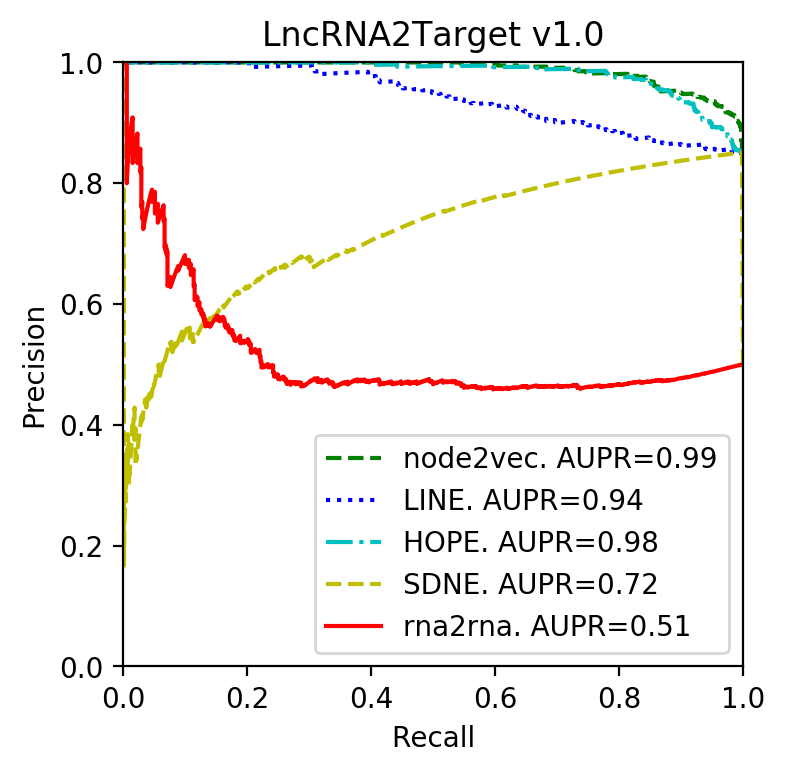

lncBase
Ed_count: 16168 , Eu_count: 0 , En_count: 0 , Ens_count 16168


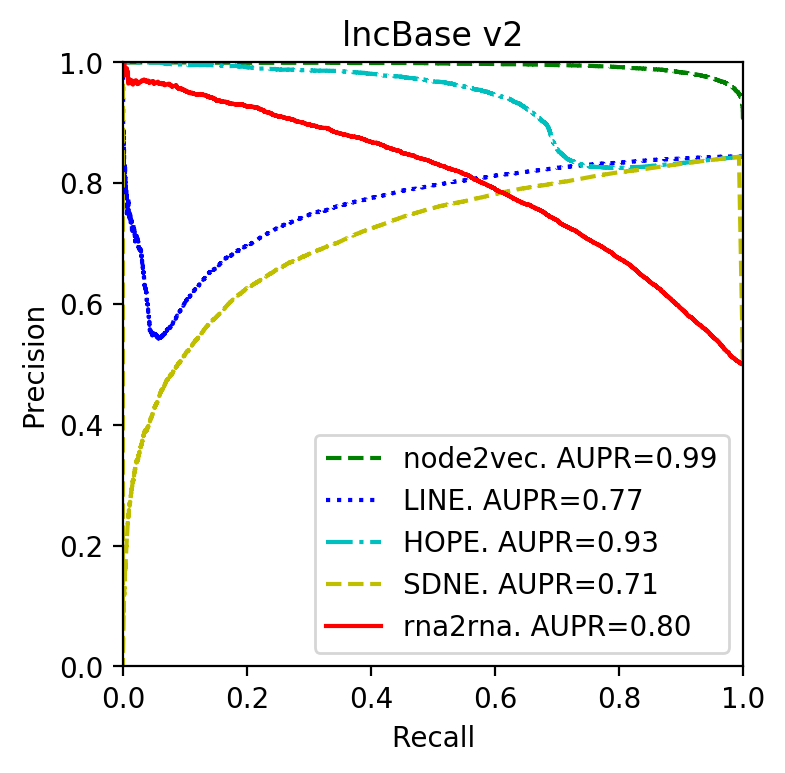

miRTarBase
Ed_count: 264960 , Eu_count: 0 , En_count: 0 , Ens_count 264960


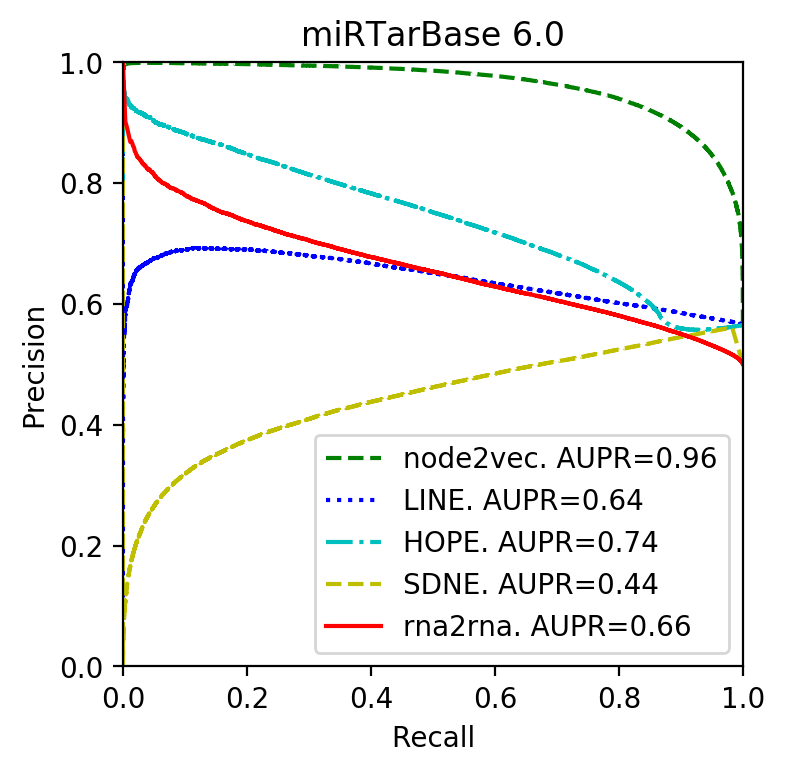

BioGRID


KeyboardInterrupt: 

In [23]:
from moge.evaluation.link_prediction import evaluate_pr_curve_link_pred, evaluate_pr_curve_link_pred_by_database
# evaluate_pr_curve_link_pred(methods, X, y_true)
evaluate_pr_curve_link_pred_by_database(methods, generator_train, 
                                        tests=[
                                            ("LNC", "GE", "lncrna2target", "LncRNA2Target v1.0"),
                                            ("MIR", "LNC", "lncBase", "lncBase v2"),
                                            ("MIR", "GE", "miRTarBase", "miRTarBase 6.0"), 
                                            ("GE", "GE", "BioGRID", "BioGRID v3.4"), 
                                            (None, None, "NPInter", "NPInter v2.0 "),
                                              ])

# Experimental Results

In [24]:
from moge.evaluation.link_prediction import evaluate_top_k_link_pred

database_tests = [
    ("LNC", "GE", "lncrna2target"),
    ("MIR", "LNC", "lncBase"),
    ("MIR", "GE", "miRTarBase"), 
    ("GE", "GE", "BioGRID"), 
    ("LNC", "GE", "lncRInter"),
    # ("LNC", "GE", "LncReg"),
]
top_k = 5000

for source, target, database in database_tests:
    print(database)
    results = {}
    for method in methods.keys():
        results[method] = \
              evaluate_top_k_link_pred(methods[method], network_train=network, network_test=network_val, 
                                       node_list=set(network.nodes[source])|set(network_val.nodes[source]), 
                                       node_list_B=set(network.nodes[target])|set(network_val.nodes[target]), 
                                       edge_type="d", databases=[database], top_k=top_k)
        
    bar_chart(results, measures=['precision', 'recall'], 
              title="Top-k (k={}) Predictions on {}".format(top_k, database))

lncrna2target


KeyboardInterrupt: 

In [ ]:
from moge.evaluation.node_clustering import evaluate_clustering

results = {}
for method in methods.keys():
    results[method] = evaluate_clustering(methods[method], network=network, node_label="locus_type", 
                                          max_clusters=500, n_clusters=None)

bar_chart(results, measures=['homogeneity', 'completeness', 'nmi'],
         title="Clustering Evaluation to {}".format("RNA Type"))

In [ ]:
from moge.evaluation.node_clustering import evaluate_clustering

results = {}
for method in methods.keys():
    results[method] = evaluate_clustering(methods[method], network=network, node_label="Family", 
                                          max_clusters=500, n_clusters=None)
    
bar_chart(results, measures=['homogeneity', 'completeness', 'nmi'], 
          title="Clustering Evaluation to {}".format("RNA Family"))

In [ ]:
from moge.evaluation.node_classification import evaluate_classification

results = {}
for method in methods.keys():
    result = {k: np.average(v) for k,v in evaluate_classification(methods[method], network, cv=10,
                                  node_label="Family", multilabel=True,
                                  scoring=['precision_macro', 'recall_macro', "f1_macro"],
                                                                verbose=True).items()}
    results[method] = result
    
bar_chart(results, measures=['test_precision_macro', 'test_recall_macro', 'test_f1_macro'])

In [ ]:
from moge.evaluation.node_classification import evaluate_classification

results = {}
for method in methods.keys():
    result = {k: np.average(v) for k,v in evaluate_classification(methods[method], network, cv=10,
                                  node_label="Disease association", multilabel=True,
                                  scoring=['precision_macro', 'recall_macro', "f1_macro"],
                                                                verbose=True).items()}
    results[method] = result
    
bar_chart(results, measures=['test_precision_macro', 'test_recall_macro', 'test_f1_macro'])

In [ ]:
from moge.evaluation.utils import get_scalefree_fit_score

results = {}
modalities = [("MIR", "LNC"), ("LNC", "MIR"), ("LNC", "GE"), ("MIR", "GE"), ("GE", "GE")]
labels = ["miRNA-lncRNA", "lncRNA-miRNA", "lncRNA-mRNA", "miRNA-mRNA", "mRNA-mRNA"]
databases = ["lncBase", "NPInter", "lncrna2target", "miRTarBase", "BioGRID"]

for method in ["Databases"]+list(methods.keys()):
    if method == "BioVec":
        continue
    elif method == "Databases":
        sub_result = {}
        for (A, B), label, database in zip(modalities, labels, databases):
            adj = network.get_adjacency_matrix(edge_types=["d"], 
                                               node_list=network.node_list,
                                               databases=[database,])
            network_degrees = np.sum(adj, axis=1)
            sub_result[label] = get_scalefree_fit_score(network_degrees, plot=False)
        results[method] = sub_result
    else:
        sub_result = {}
        for (A, B), label in zip(modalities, labels):
           sub_result[label] = methods[method].get_scalefree_fit_score(network.nodes[A], network.nodes[B])
        results[method] = sub_result
    
bar_chart(results, measures=labels, title="Scale-free fit scores", loc="lower right")

# Visualization

In [34]:
modalities = [("MIR", "LNC", "lncBase"), 
              ("LNC", "MIR", "NPInter"), 
              ("LNC", "GE", "lncrna2target"), 
              ("MIR", "GE", "miRTarBase"), 
              ("GE", "GE", "BioGRID")
             ]

nodes_inters_dict = {}
for A, B, database in modalities:
    edge_list = [(u,v,d) for u,v,d in network.G.edges(data=True) if "database" in d and d["database"]==database and\
                u in network.nodes[A] and v in network.nodes[B]]
    nodes_inters_dict[(A, B)] = {}
    nodes_inters_dict[(A, B)][A] = {u for u,v,d in edge_list}
    nodes_inters_dict[(A, B)][B] = {v for u,v,d in edge_list}

In [35]:
nodes_inters_dict_2 = dict.fromkeys(rna2rna_emb.node_list, 0)

for A, B, database in modalities:
    if database == "BioGRID": continue
    for node in nodes_inters_dict[(A, B)][A]:
        if node in nodes_inters_dict_2:
            nodes_inters_dict_2[node] = nodes_inters_dict_2[node] + 1
    for node in nodes_inters_dict[(A, B)][B]:
        if node in nodes_inters_dict_2:
            nodes_inters_dict_2[node] = nodes_inters_dict_2[node] + 1
        
trimodule_nodes = [k for k,v in nodes_inters_dict_2.items() if (k in network.nodes["LNC"] and v >= 2) or \
                   (k in network.nodes["MIR"] and v >= 2) or \
                  (k in network.nodes["GE"] and v >= 2)]
[(m, len(set(trimodule_nodes) & set(network.nodes[m]))) for m in ["LNC", "MIR", "GE"]]

[('LNC', 248), ('MIR', 909), ('GE', 8718)]

In [27]:
set(trimodule_nodes) & set(network.nodes["LNC"])

{'AFAP1-AS1',
 'CASC2',
 'CRNDE',
 'CYTOR',
 'DLEU2',
 'EMX2OS',
 'FENDRR',
 'GAS5',
 'H19',
 'HAGLR',
 'HCP5',
 'HNF1A-AS1',
 'HOTAIR',
 'HOTAIRM1',
 'HOTTIP',
 'HOXA-AS2',
 'HOXA-AS3',
 'LINC-ROR',
 'LINC00052',
 'LINC00511',
 'MALAT1',
 'MEG3',
 'MIAT',
 'MIR7-3HG',
 'NEAT1',
 'PVT1',
 'SNHG1',
 'SNHG12',
 'SNHG14',
 'SNHG15',
 'SNHG16',
 'SNHG5',
 'SNHG7',
 'SOX2-OT',
 'TP53TG1',
 'TUG1',
 'UCA1',
 'XIST',
 'ZEB1-AS1',
 'ZFAS1'}

In [36]:
g = network.G.subgraph(trimodule_nodes).to_undirected()
center_node = "XIST"
nodelist = list(g.neighbors(center_node))+[center_node]
len(nodelist)

525

In [ ]:
predicted_edges = siamese.get_top_k_predicted_edges(edge_type="d", top_k=50, 
                                  node_list=[center_node],
                                  node_list_B=network.node_list,
                                  training_network=network,)
predicted_edges

In [ ]:
layout = nx.spring_layout(network.G.subgraph(nodelist), 
#                           weight='weight',
                          k=15.0/len(nodelist)**0.5,
                          iterations=100)

In [ ]:
visualize_embedding(rna2rna_emb, network=network, 
                    nodelist=nodelist,
                    node_label="RNA Type", # sc.tolist(), 
                    node_pos=layout,
                    top_k=0,
                    edgelist=network.get_edgelist(node_list=nodelist, inclusive=True),
#                     test_nodes=siamese.generator_val.get_nonzero_nodelist(),
                    cmap="viridis",
                    figsize=(8, 8), dpi=150,
                    with_labels=True, font_size=0, labels=None, arrowsize=6,
                    node_size="centrality", 
                    file_name="moge/data/Results/vis_lncRNAs/{}".format(center_node),
                   )

In [ ]:
visualize_embedding(rna2rna_emb, network=network, 
                    nodelist=nodelist,
                    node_label="locus_type", # sc.tolist(), 
                    top_k=0,
                    edgelist=network.get_edgelist(node_list=nodelist, inclusive=True),
#                     test_nodes=siamese.generator_val.get_nonzero_nodelist(),
                    cmap="gist_ncar",
                    node_size="centrality", 
                    with_labels=True, font_size=0, labels=None, arrowsize=9,
                    figsize=(10,10), dpi=150,
#                     file_name="moge/data/Results/siamese_online_triplet_euclidean",
                   )

In [ ]:
# siamese.process_embeddings(variable_length=True, minlen=200)
# delattr(siamese, "node_pos")
visualize_embedding(siamese, network=network, node_label="locus_type", 
#                     edgelist=network_val.get_edgelist(node_list=nodes_to_visualize, 
#                                                       edge_types=["d"])[:500],
#                     test_nodes=nodes_test,
                    cmap="gist_ncar",)

In [ ]:
# nx.write_edgelist(network.G.subgraph(nodelist), "./moge/data/Networks/{}.edgelist".format(center_node))

In [ ]:
plot_bokeh_graph(network.G.subgraph(nodelist), node_pos=layout,
                 node_label=network.genes_info.loc[nodelist, "locus_type"].values.tolist())

# AUC Rate

%%javascript
Jupyter.notebook.session.delete();